# 🌊 Klasifikasi Kualitas Air Sungai Citarum Menggunakan Machine Learning

## 📘 Deskripsi Dataset
Dataset ini berisi parameter-parameter kimia dan biologis dari berbagai titik pantau Sungai Citarum, seperti:
- **Fitur**: pH, Suhu, TSS, DO, BOD, COD, Nitrat, Fosfat, FecalColiform, dan Indeks Pencemar (IP)
- **Target (Class)**: Kategori kualitas air, yaitu kelas 1 hingga 4

---

## ⚙️ Langkah Preprocessing
1. Menghapus kolom non-numerik dan informasi lokasi/waktu (`No`, `NamaSungai`, dll.)
2. Mengubah format suhu dari string ke angka (`25.5°C` → `25.5`)
3. Menghapus baris yang memiliki nilai kosong (missing values)
4. Menormalisasi fitur dengan **StandardScaler**
5. Split data: **80% training**, **20% testing** (stratified untuk menjaga distribusi kelas)

---

## 🤖 Model Machine Learning

### 1. Random Forest Classifier (Bagging)
- Menggunakan banyak decision tree secara paralel
- Voting mayoritas untuk prediksi akhir
- Cocok untuk dataset dengan noise & variabel tidak linier

### 2. Gradient Boosting Classifier (Boosting)
- Membuat model secara bertahap, setiap model memperbaiki kesalahan sebelumnya
- Sangat efektif untuk data tabular
- Lebih presisi dibanding bagging, meskipun sedikit lebih lambat

---

## 📊 Evaluasi Model

### Metode Evaluasi:
- **Accuracy**: Proporsi prediksi benar dari seluruh data
- **Precision (macro)**: Rata-rata presisi antar kelas
- **Recall (macro)**: Kemampuan menangkap semua label tiap kelas
- **F1 Score (macro)**: Harmonik antara precision dan recall
- **AUC OvR (macro)**: Kemampuan model membedakan satu kelas terhadap semua kelas lainnya

---

## 📈 ROC Curve (Multiclass One-vs-Rest)
- Setiap kurva menunjukkan kemampuan model dalam membedakan satu kelas dari yang lain
- Area di bawah kurva (AUC) mendekati 1 menunjukkan performa yang sangat baik

---

## 🔲 Confusion Matrix
Visualisasi prediksi model terhadap label asli:
- Sumbu vertikal: Label aktual
- Sumbu horizontal: Prediksi model

Confusion Matrix menunjukkan seberapa banyak model salah atau benar dalam tiap kelas.

---



=== Random Forest (Bagging) ===
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       190
           2       1.00      1.00      1.00       299
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         3

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

AUC (OvR Macro): 1.0000

=== Gradient Boosting (Boosting) ===
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       190
           2       1.00      1.00      1.00       299
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         3

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

AUC (OvR Macro): 1.0000


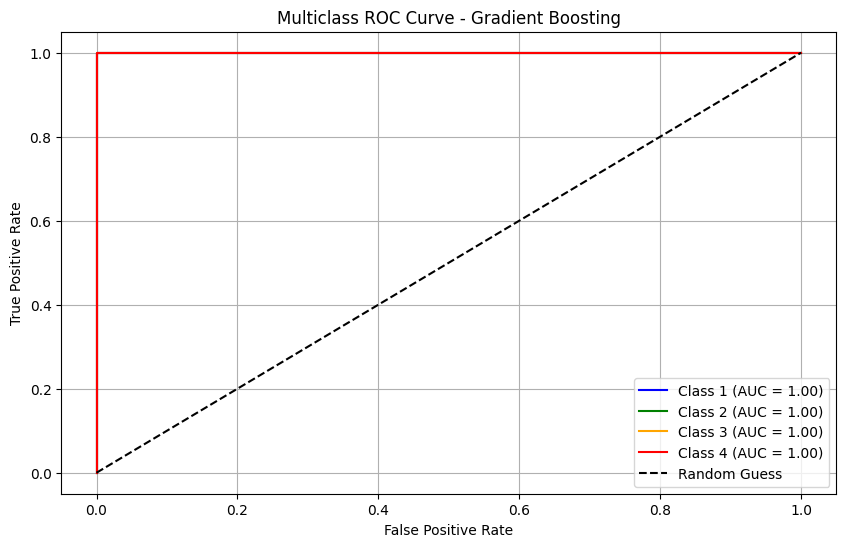

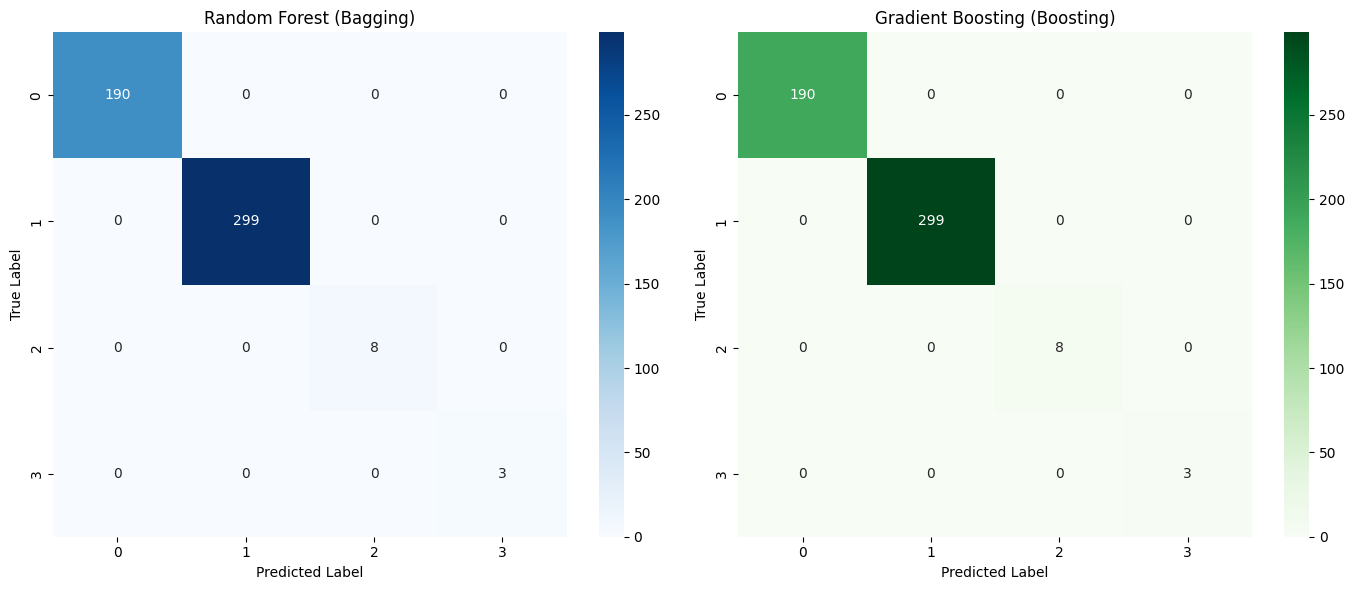

In [3]:
# === 1. Import Library ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# === 2. Load Dataset ===
df = pd.read_csv("/content/CitarumWater.csv")  # Ganti path jika perlu
df = df.drop(columns=['No', 'NamaSungai', 'TitikPantau', 'Waktu', 'O2'])  # Drop kolom non-fitur
df['Temp'] = df['Temp'].str.replace('°C', '').astype(float)  # Bersihkan suhu
df = df.dropna()

# === 3. Target dan Fitur ===
X = df.drop(columns='Class')
y = df['Class']

# === 4. Split Fitur dan Target ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 5. Normalisasi Data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 6. Model Bagging: Random Forest ===
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)

# === 7. Model Boosting: Gradient Boosting ===
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_proba = gb_model.predict_proba(X_test_scaled)

# === 8. Evaluasi Model ===
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred))
    auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    print(f"AUC (OvR Macro): {auc:.4f}")
    return auc

rf_auc = evaluate_model("Random Forest (Bagging)", y_test, rf_pred, rf_proba)
gb_auc = evaluate_model("Gradient Boosting (Boosting)", y_test, gb_pred, gb_proba)

# === 9. ROC Curve Multiclass ===
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test_bin.shape[1]
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], gb_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], gb_proba[:, i])
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve - Gradient Boosting")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# === 10. Confusion Matrix ===
rf_cm = confusion_matrix(y_test, rf_pred)
gb_cm = confusion_matrix(y_test, gb_pred)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Random Forest (Bagging)")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

sns.heatmap(gb_cm, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("Gradient Boosting (Boosting)")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()
